# Задание

Отслеживание вычислительных затрат Spark приложения при запуске на Hadoop с разными настройками. Работа состоит из следующих шагов:
* Подготовить датасет, в котором будет 100 000+ записей, каждая из которых будет иметь 6+ признаков (минимум 3 разных типа, один из которых категориальный).
* Развернуть Hadoop, ограничив размер блока и используемую память, и запустить на нём приложение на Spark с различными параметрами:
    * 1 DataNode, без оптимизации Spark приложения
    * 3 DataNode, без оптимизации Spark приложения
    * 1 DataNode, с оптимизацией Spark приложения
    * 3 DataNode, с оптимизацией Spark приложения
* Сравнить получившиеся результаты.

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2
* pyspark==3.5.1

In [4]:
import pandas as pd # для удобной работы с датасетом
import re # регулярные выражения

import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для графиков

import warnings # для обработки предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning) # игнорируем FutureWarning

In [3]:
DATA_DIR = "./data/" # путь до папки с данными
LOGS_DIR = "./logs/" # путь до папки с логами
RANDOM_STATE = 42 # число для задания случайности

In [3]:
# from google.colab import drive # для Google Drive
# drive.mount('/content/drive') # подключаемся к Google Drive

# # перезаписываем важные переменные
# DATA_DIR = "/content/drive/MyDrive/tmp/data/" # путь до папки с данными

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка датасета

В качестве рассматриваемого датасета был выбран [Credit Card Fraud Prediction](https://www.kaggle.com/datasets/kelvinkelue/credit-card-fraud-prediction/), содержащий различные данные о транзакциях (в нём нет пропущенных значений).

Цель — определить, является ли проведённая операция мошеннической или нет.

**Столбцы:**
1) Trans_date_trans_time: timestamp транзакции (дата и время).
2) Cc_num: уникальный идентификационный номер покупателя.
3) Merchant: продавец, участвующий в сделке.
4) Category: тип транзакции (например: personal или childcare).
5) Amt: сумма транзакции.
6) First: имя владельца карты.
7) Last фамилия владельца карты.
8) Gender: пол владельца карты.
9) Street: улица проживания владельца карты.
10) City: город проживания владельца карты.
11) State: страна проживания владельца карты.
12) Zip: zip code владельца карты.
13) Lat: широта местоположения владельца карты.
14) Long: долгота местоположения владельца карты.
15) City_pop: население города владельца карты.
16) Job: должность владельца карты.
17) Dob: дата рождения владельца карты.
18) Trans_num: уникальный идентификатор транзакции.
19) Unix_time: timestamp транзакции (Unix формат).
20) Merch_lat: местоположение продавца (широта).
21) Merch_long: местоположение продавца (долгота).
22) Is_fraud: индикатор мошеннической транзакции (0 — законная, 1 — мошенническая), является target-переменной задачи классификации.

In [4]:
dataset = pd.read_csv(f"{DATA_DIR}fraud test.csv",  sep=',', encoding='utf8', index_col=0) # считывание данных (колонки разделены с помощью sep, данные хранятся в кодировке encoding, индексы указаны в колонке index_col (None, если в данных её изначально нет))
dataset

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,31/12/2020 23:59,3.056060e+13,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,40.4931,-91.8912,519,Town planner,13/02/1966,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,31/12/2020 23:59,3.556610e+15,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,29.0393,-95.4401,28739,Futures trader,27/12/1999,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,31/12/2020 23:59,6.011720e+15,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,46.1966,-118.9017,3684,Musician,29/11/1981,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,31/12/2020 23:59,4.079770e+12,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,44.6255,-116.4493,129,Cartographer,15/12/1965,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  float64
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-null  i

In [6]:
dataset["is_fraud"].value_counts() # баланс классов сильно несбалансированный

is_fraud
0    553574
1      2145
Name: count, dtype: int64

**Удалим из датасета те столбцы, что не должны нести информацию о мошенничестве.**

Среди данных столбцов (они субъективны): first, last, street, city, state (вместо них есть точное положение lat, long), zip, trans_num, unix_time.

In [7]:
dataset.drop(columns=["first", "last", "street", "city", "state", "zip", "trans_num", "unix_time"], inplace=True) # удаляем лишние столбцы
dataset

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud
0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,M,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,33.986391,-81.200714,0
1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,F,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,39.450498,-109.960431,0
2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,40.495810,-74.196111,0
3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,M,28.5697,-80.8191,54767,Set designer,25/07/1987,28.812398,-80.883061,0
4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,M,44.2529,-85.0170,1126,Furniture designer,06/07/1955,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,31/12/2020 23:59,3.056060e+13,fraud_Reilly and Sons,health_fitness,43.77,M,40.4931,-91.8912,519,Town planner,13/02/1966,39.946837,-91.333331,0
555715,31/12/2020 23:59,3.556610e+15,fraud_Hoppe-Parisian,kids_pets,111.84,M,29.0393,-95.4401,28739,Futures trader,27/12/1999,29.661049,-96.186633,0
555716,31/12/2020 23:59,6.011720e+15,fraud_Rau-Robel,kids_pets,86.88,F,46.1966,-118.9017,3684,Musician,29/11/1981,46.658340,-119.715054,0
555717,31/12/2020 23:59,4.079770e+12,fraud_Breitenberg LLC,travel,7.99,M,44.6255,-116.4493,129,Cartographer,15/12/1965,44.470525,-117.080888,0


Оставшиеся данные получились следующие:
* Trans_date_trans_time: время транзакции (**числовой ~ date признак**).
* Cc_num: уникальный номер покупателя (**числовой признак**).
* Merchant: продавец, участвующий в сделке (**категориальный признак**).
* Category: тип транзакции (**категориальный признак**).
* Amt: сумма транзакции (**числовой признак**).
* Gender: пол владельца карты (**категориальный признак**).
* Lat: широта местоположения владельца карты (**числовой признак**).
* Long: долгота местоположения владельца карты (**числовой признак**).
* City_pop: население города владельца карты (**числовой признак**).
* Job: должность владельца карты (**категориальный признак**).
* Dob: дата рождения владельца карты (**числовой ~ date признак**).
* Merch_lat: местоположение продавца (широта) (**числовой признак**).
* Merch_long: местоположение продавца (долгота) (**числовой признак**).
* Is_fraud: индикатор мошеннической транзакции (**бинарный признак**).

Отберём 200 000 записей из датасета произвольным образом для Spark приложения.

In [8]:
dataset = dataset.sample(frac=1, random_state=RANDOM_STATE) # случайно перемешиваем строки (так как frac=1, то выборка не уменьшится, а просто перемешается)
dataset.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)

In [9]:
dataset = dataset[:200000] # оставляем только 200000 записей
dataset

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud
0,02/08/2020 07:55,3.778960e+14,"fraud_Bahringer, Schoen and Corkery",shopping_pos,1.07,F,41.4682,-72.5751,5438,"Librarian, academic",17/11/1964,41.240083,-71.837788,0
1,23/08/2020 14:05,3.036410e+13,"fraud_Romaguera, Wehner and Tromp",kids_pets,94.99,M,35.8896,-96.0887,7163,Fitness centre manager,05/02/1982,35.156537,-95.806648,0
2,28/12/2020 16:22,3.032840e+13,fraud_Berge-Hills,kids_pets,31.28,F,40.0290,-93.1607,602,Cytogeneticist,14/07/1954,39.888665,-93.106804,0
3,14/11/2020 10:44,3.036410e+13,"fraud_Connelly, Reichert and Fritsch",gas_transport,73.06,M,35.8896,-96.0887,7163,Fitness centre manager,05/02/1982,36.734101,-96.737345,0
4,19/10/2020 01:50,4.198470e+12,fraud_Kuphal-Predovic,misc_net,9.99,F,41.4768,-95.3509,2036,Engineering geologist,20/08/1971,40.922072,-94.899388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,25/06/2020 20:16,3.533800e+15,fraud_O'Connell-Ullrich,home,209.50,F,40.2967,-98.7370,493,"Surveyor, minerals",13/09/1940,40.070009,-98.411600,0
199996,28/12/2020 16:14,4.302480e+15,fraud_Friesen-Ortiz,personal_care,1.97,M,43.2326,-86.2492,128715,Historic buildings inspector/conservation officer,25/05/1995,44.075150,-86.275686,0
199997,06/12/2020 16:08,5.718440e+11,"fraud_Lang, Towne and Schuppe",kids_pets,129.65,F,38.2507,-85.7476,736284,Engineering geologist,02/04/1952,38.988449,-84.974224,0
199998,28/10/2020 00:19,3.010310e+13,fraud_Dach-Nader,misc_net,7.24,F,41.0001,-78.2357,3688,Dispensing optician,26/10/1987,41.616159,-78.738506,0


In [10]:
dataset.to_csv(f"{DATA_DIR}data_simple.csv", sep=",", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)

# Spark приложение

## Общие настройки для Spark.

In [36]:
from pyspark.sql import SparkSession # для создания Spark сессии
from pyspark.sql.functions import unix_timestamp, col, isnan, when, count # функции для работы с данными
from pyspark.sql.types import FloatType # типы переменных
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler # StringIndexer — конвертер категориальных переменных в числовые; OneHotEncoder — One-hot encoder признаков, VectorAssembler — для объединения нескольких числовых переменных в одну
from pyspark.ml.classification import GBTClassifier # модель

import matplotlib.pyplot as plt # для построения графиков
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний

In [12]:
spark = SparkSession.builder.master("local").appName("practice").getOrCreate() # создание Spark сессии (getOrCreate) с указанием spark-master (master: local — мастером является это же устройство), и названием (appName)
# spark = SparkSession.builder.master("spark://spark-master:7077").appName("practice").getOrCreate() # создание Spark сессии (getOrCreate) с указанием spark-master (master: spark://spark-master:7077 — URL до мастера), и названием (appName)
spark

## Считывание данных.

In [23]:
data = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load(f"{DATA_DIR}data_simple.csv")
# read — считываем данные
# format — формат данных
# option — опции для считывания (header=true — в файле первая строка выступает как заголовок, inferSchema — кастить ли типы не только к строке)
# load — путь до файла
data

DataFrame[trans_date_trans_time: string, cc_num: double, merchant: string, category: string, amt: double, gender: string, lat: double, long: double, city_pop: int, job: string, dob: string, merch_lat: double, merch_long: double, is_fraud: int]

In [24]:
data.show(5) # вывод первых пяти элементов

+---------------------+----------+--------------------+-------------+-----+------+-------+--------+--------+--------------------+----------+---------+----------+--------+
|trans_date_trans_time|    cc_num|            merchant|     category|  amt|gender|    lat|    long|city_pop|                 job|       dob|merch_lat|merch_long|is_fraud|
+---------------------+----------+--------------------+-------------+-----+------+-------+--------+--------+--------------------+----------+---------+----------+--------+
|     02/08/2020 07:55|3.77896E14|fraud_Bahringer, ...| shopping_pos| 1.07|     F|41.4682|-72.5751|    5438| Librarian, academic|17/11/1964|41.240083|-71.837788|       0|
|     23/08/2020 14:05|3.03641E13|fraud_Romaguera, ...|    kids_pets|94.99|     M|35.8896|-96.0887|    7163|Fitness centre ma...|05/02/1982|35.156537|-95.806648|       0|
|     28/12/2020 16:22|3.03284E13|   fraud_Berge-Hills|    kids_pets|31.28|     F| 40.029|-93.1607|     602|      Cytogeneticist|14/07/1954|39.88

In [25]:
type(data) # тип полученного объекта

pyspark.sql.dataframe.DataFrame

In [26]:
data.printSchema() # вывод характеристик прочитанных данных

root
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: double (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [27]:
data.describe().show() # вывод основной информации о данных

+-------+---------------------+--------------------+-------------------+-------------+------------------+------+-----------------+------------------+-----------------+------------------+----------+------------------+-----------------+-------------------+
|summary|trans_date_trans_time|              cc_num|           merchant|     category|               amt|gender|              lat|              long|         city_pop|               job|       dob|         merch_lat|       merch_long|           is_fraud|
+-------+---------------------+--------------------+-------------------+-------------+------------------+------+-----------------+------------------+-----------------+------------------+----------+------------------+-----------------+-------------------+
|  count|               200000|              200000|             200000|       200000|            200000|200000|           200000|            200000|           200000|            200000|    200000|            200000|           200000| 

In [28]:
data.count() # число записей (строк) в DataFrame

200000

## Предобработка данных в Spark.

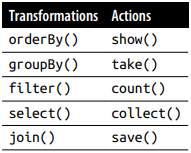

In [29]:
def is_missing(dataframe):
    return dataframe.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataframe.columns]).show()

In [30]:
is_missing(data) # вывод количества записей с NaN значениями

+---------------------+------+--------+--------+---+------+---+----+--------+---+---+---------+----------+--------+
|trans_date_trans_time|cc_num|merchant|category|amt|gender|lat|long|city_pop|job|dob|merch_lat|merch_long|is_fraud|
+---------------------+------+--------+--------+---+------+---+----+--------+---+---+---------+----------+--------+
|                    0|     0|       0|       0|  0|     0|  0|   0|       0|  0|  0|        0|         0|       0|
+---------------------+------+--------+--------+---+------+---+----+--------+---+---+---------+----------+--------+



In [31]:
data = data.withColumn("trans_date_trans_time", (unix_timestamp("trans_date_trans_time", format='dd/MM/yyyy HH:mm') / 86400).cast(FloatType())) # конвертируем столбец типа str сначала в date (unix_timestamp), а потом в float (cast(FloatType()))
data = data.withColumn("dob", (unix_timestamp("dob", format='dd/MM/yyyy') / 86400).cast(FloatType())) # конвертируем столбец типа str сначала в date (unix_timestamp), а потом в float (cast(FloatType()))
data.show(5)

+---------------------+----------+--------------------+-------------+-----+------+-------+--------+--------+--------------------+-------+---------+----------+--------+
|trans_date_trans_time|    cc_num|            merchant|     category|  amt|gender|    lat|    long|city_pop|                 job|    dob|merch_lat|merch_long|is_fraud|
+---------------------+----------+--------------------+-------------+-----+------+-------+--------+--------+--------------------+-------+---------+----------+--------+
|             18476.33|3.77896E14|fraud_Bahringer, ...| shopping_pos| 1.07|     F|41.4682|-72.5751|    5438| Librarian, academic|-1871.0|41.240083|-71.837788|       0|
|            18497.586|3.03641E13|fraud_Romaguera, ...|    kids_pets|94.99|     M|35.8896|-96.0887|    7163|Fitness centre ma...| 4418.0|35.156537|-95.806648|       0|
|            18624.682|3.03284E13|   fraud_Berge-Hills|    kids_pets|31.28|     F| 40.029|-93.1607|     602|      Cytogeneticist|-5650.0|39.888665|-93.106804|  

In [32]:
for col in ["merchant", "category", "gender", "job"]: # идём по некоторым категориальным колонкам
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index") # создаём объект для трансформации категориальных признаков в int (inputCol — входная колонка, outputCol — выходная колонка)
    data = indexer.fit(data).transform(data) # обучаем (fit) на данных и трансформируем (transform) их
    data = data.drop(col) # удаляем предыдущую колонку
    data = data.withColumnRenamed(f"{col}_index",col) # переименовываем новую в старую
data.show(5)

+---------------------+----------+-----+-------+--------+--------+-------+---------+----------+--------+--------+--------+------+-----+
|trans_date_trans_time|    cc_num|  amt|    lat|    long|city_pop|    dob|merch_lat|merch_long|is_fraud|merchant|category|gender|  job|
+---------------------+----------+-----+-------+--------+--------+-------+---------+----------+--------+--------+--------+------+-----+
|             18476.33|3.77896E14| 1.07|41.4682|-72.5751|    5438|-1871.0|41.240083|-71.837788|       0|   138.0|     3.0|   0.0| 54.0|
|            18497.586|3.03641E13|94.99|35.8896|-96.0887|    7163| 4418.0|35.156537|-95.806648|       0|   212.0|     4.0|   1.0|234.0|
|            18624.682|3.03284E13|31.28| 40.029|-93.1607|     602|-5650.0|39.888665|-93.106804|       0|   139.0|     4.0|   0.0| 53.0|
|            18580.447|3.03641E13|73.06|35.8896|-96.0887|    7163| 4418.0|36.734101|-96.737345|       0|    54.0|     0.0|   1.0|234.0|
|            18554.076|4.19847E12| 9.99|41.4768|

In [33]:
one_hot_encoder = OneHotEncoder(inputCol='gender', outputCol='gender_one_hot') # объект для One-hot кодирования колонки
one_hot_encoder = one_hot_encoder.fit(data) # обучаем энкодер на данных
data = one_hot_encoder.transform(data) # трансформируем данные
data = data.drop('gender') # удаляем предыдущую колонку
data.show(5)

+---------------------+----------+-----+-------+--------+--------+-------+---------+----------+--------+--------+--------+-----+--------------+
|trans_date_trans_time|    cc_num|  amt|    lat|    long|city_pop|    dob|merch_lat|merch_long|is_fraud|merchant|category|  job|gender_one_hot|
+---------------------+----------+-----+-------+--------+--------+-------+---------+----------+--------+--------+--------+-----+--------------+
|             18476.33|3.77896E14| 1.07|41.4682|-72.5751|    5438|-1871.0|41.240083|-71.837788|       0|   138.0|     3.0| 54.0| (1,[0],[1.0])|
|            18497.586|3.03641E13|94.99|35.8896|-96.0887|    7163| 4418.0|35.156537|-95.806648|       0|   212.0|     4.0|234.0|     (1,[],[])|
|            18624.682|3.03284E13|31.28| 40.029|-93.1607|     602|-5650.0|39.888665|-93.106804|       0|   139.0|     4.0| 53.0| (1,[0],[1.0])|
|            18580.447|3.03641E13|73.06|35.8896|-96.0887|    7163| 4418.0|36.734101|-96.737345|       0|    54.0|     0.0|234.0|     (1,

In [34]:
numeric_cols = ["trans_date_trans_time", "cc_num", "amt", "lat", "long", "city_pop", "dob", "merch_lat", "merch_long", "merchant", "category", "job", "gender_one_hot"] # список с числовыми колонками

assembler = VectorAssembler(inputCols=numeric_cols, outputCol='vectorized_data') # объект для комбинации данных из колонок inputCols в outputCol
data = assembler.transform(data) # комбинируем данные из колонок
data.show(5)

+---------------------+----------+-----+-------+--------+--------+-------+---------+----------+--------+--------+--------+-----+--------------+--------------------+
|trans_date_trans_time|    cc_num|  amt|    lat|    long|city_pop|    dob|merch_lat|merch_long|is_fraud|merchant|category|  job|gender_one_hot|     vectorized_data|
+---------------------+----------+-----+-------+--------+--------+-------+---------+----------+--------+--------+--------+-----+--------------+--------------------+
|             18476.33|3.77896E14| 1.07|41.4682|-72.5751|    5438|-1871.0|41.240083|-71.837788|       0|   138.0|     3.0| 54.0| (1,[0],[1.0])|[18476.330078125,...|
|            18497.586|3.03641E13|94.99|35.8896|-96.0887|    7163| 4418.0|35.156537|-95.806648|       0|   212.0|     4.0|234.0|     (1,[],[])|[18497.5859375,3....|
|            18624.682|3.03284E13|31.28| 40.029|-93.1607|     602|-5650.0|39.888665|-93.106804|       0|   139.0|     4.0| 53.0| (1,[0],[1.0])|[18624.681640625,...|
|         

Train-test split.

In [35]:
data_train, data_test = data.randomSplit([0.7, 0.3]) # разбиваем данные на обучающую и тестовую выборки

## Обучение модели

In [47]:
model = GBTClassifier(featuresCol="vectorized_data", labelCol="is_fraud", maxBins=700) # модель для классификации
model

GBTClassifier_519aea88fb6d

In [48]:
model = model.fit(data_train) # обучаем модель на тренировочных данных
model

GBTClassificationModel: uid = GBTClassifier_519aea88fb6d, numTrees=20, numClasses=2, numFeatures=13

## Сравнение качества

In [49]:
pred_test = model.transform(data_test) # делаем предсказание на тестовых данных
pred_test = pred_test.toPandas() # конвертируем в pandas.DataFrame
pred_test

,trans_date_trans_time,cc_num,amt,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,merchant,category,job,gender_one_hot,vectorized_data,rawPrediction,probability,prediction
0,18434.511719,5.714650e+11,42.40,43.0048,-108.8964,1645,2247.0,42.687774,-108.670054,0,241.0,4.0,145.0,(0.0),"[18434.51171875, 571465000000.0, 42.4, 43.0048...","[1.5436918557024337, -1.5436918557024337]","[0.9563693253236909, 0.0436306746763091]",0.0
1,18434.513672,3.725090e+14,9.87,42.9147,-83.4845,6951,5647.0,43.702833,-83.750248,0,206.0,3.0,126.0,(1.0),"[18434.513671875, 372509000000000.0, 9.87, 42....","[1.5436918557024337, -1.5436918557024337]","[0.9563693253236909, 0.0436306746763091]",0.0
2,18434.515625,6.011920e+15,1.70,43.1699,-72.8515,828,-4507.0,42.390565,-71.932418,0,469.0,9.0,242.0,(0.0),"[18434.515625, 6011920000000000.0, 1.7, 43.169...","[1.546617209326527, -1.546617209326527]","[0.9566128072012026, 0.043387192798797436]",0.0
3,18434.519531,4.783230e+12,46.67,38.5957,-99.5540,320,-3176.0,39.456658,-99.569786,0,396.0,6.0,0.0,(1.0),"[18434.51953125, 4783230000000.0, 46.67, 38.59...","[1.5436918557024337, -1.5436918557024337]","[0.9563693253236909, 0.0436306746763091]",0.0
4,18434.519531,3.770270e+14,5.36,37.3272,-91.0243,241,1760.0,38.211238,-90.421871,0,386.0,9.0,193.0,(1.0),"[18434.51953125, 377027000000000.0, 5.36, 37.3...","[1.5436918557024337, -1.5436918557024337]","[0.9563693253236909, 0.0436306746763091]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60174,18627.990234,3.002680e+13,69.21,32.9013,-91.0286,595,3532.0,32.356708,-91.578287,0,260.0,8.0,84.0,(0.0),"[18627.990234375, 30026800000000.0, 69.21, 32....","[1.5475865353774796, -1.5475865353774796]","[0.9566931992716635, 0.04330680072833648]",0.0
60175,18627.992188,2.222000e+15,52.97,38.9318,-89.9618,2401,732.0,38.352049,-90.416444,0,34.0,2.0,111.0,(1.0),"[18627.9921875, 2222000000000000.0, 52.97, 38....","[1.5436918557024337, -1.5436918557024337]","[0.9563693253236909, 0.0436306746763091]",0.0
60176,18627.998047,3.523840e+15,17.00,32.6176,-86.9475,1412,323.0,32.164145,-87.539669,0,147.0,2.0,64.0,(1.0),"[18627.998046875, 3523840000000000.0, 17.0, 32...","[1.5436918557024337, -1.5436918557024337]","[0.9563693253236909, 0.0436306746763091]",0.0
60177,18628.000000,4.079770e+12,7.99,44.6255,-116.4493,129,-1478.0,44.470525,-117.080888,0,675.0,13.0,255.0,(0.0),"[18628.0, 4079770000000.0, 7.99, 44.6255, -116...","[1.5436918557024337, -1.5436918557024337]","[0.9563693253236909, 0.0436306746763091]",0.0


In [50]:
labels = ["не мошенничество", "мошенничество"]
y_true = pred_test["is_fraud"].values
y_pred = pred_test["prediction"].values
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [51]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=labels)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)

                  precision    recall  f1-score   support

не мошенничество       1.00      1.00      1.00     59950
   мошенничество       0.38      0.56      0.45       229

        accuracy                           0.99     60179
       macro avg       0.69      0.78      0.72     60179
    weighted avg       1.00      0.99      1.00     60179



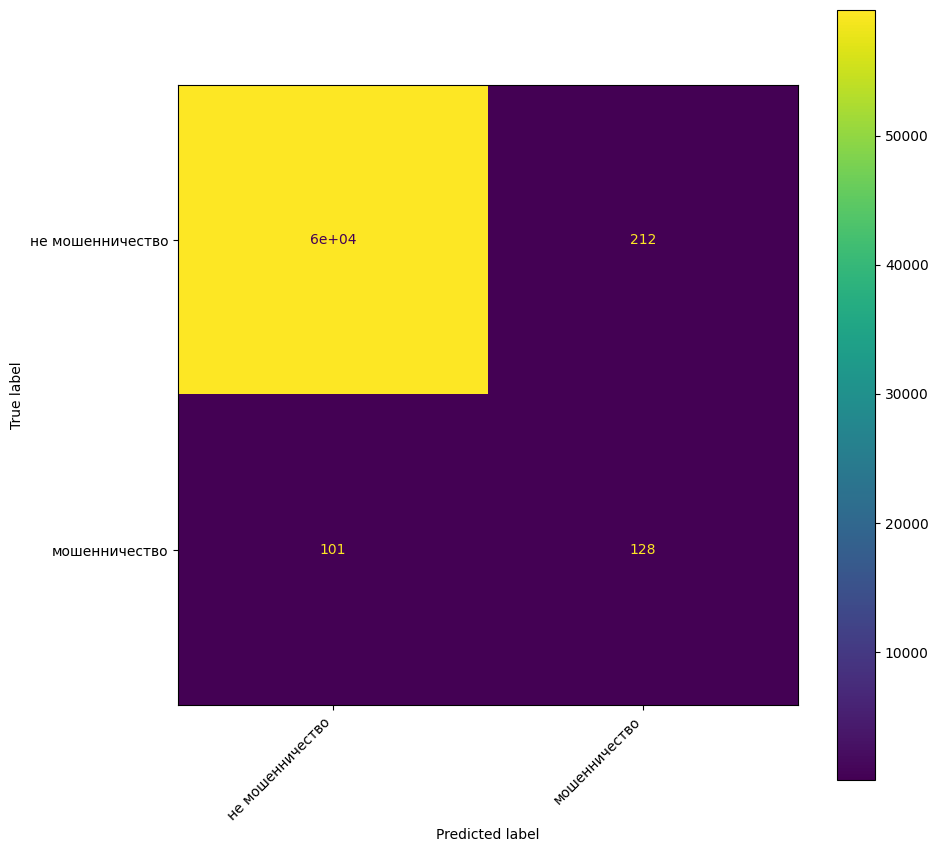

In [52]:
fig, ax = plt.subplots(figsize=(10,10)) # создание фигуры
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels).plot(ax=ax) # строим confusion matrix (стоит обратить внимание на display_labels, они могут не совпасть...)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
plt.show() # показ фигуры

# Обработка полученных результатов Spark приложения

Результаты получены при помощи запуска команд, указанных в ```./README.md```.

In [12]:
res = {} # словарь под результаты

for datanodes in [1, 3]: # идём по числу рассматриваемых DataNode
    res[datanodes] = {} # подсловарь под наличие оптимизации
    for optimized in ["True", "False"]: # идём по флагу наличия оптимизации
        res[datanodes][optimized] = {"Time": [], "RAM": []} # подсловарь под данные о времени выполнения и затраченной оперативной памяти

        with open(f"{LOGS_DIR}log_DataNodes_{datanodes}_opt_{optimized}.txt", "r") as f: # открываем файл для чтения (r)
            for line in f.readlines(): # идём по строкам файла
                numbers = re.findall(r'\d+.\d+', line) # ищем числа в строке
                res[datanodes][optimized]["Time"].append(float(numbers[0])) # запоминаем время работы
                res[datanodes][optimized]["RAM"].append(float(numbers[1])) # запоминаем использованную RAM

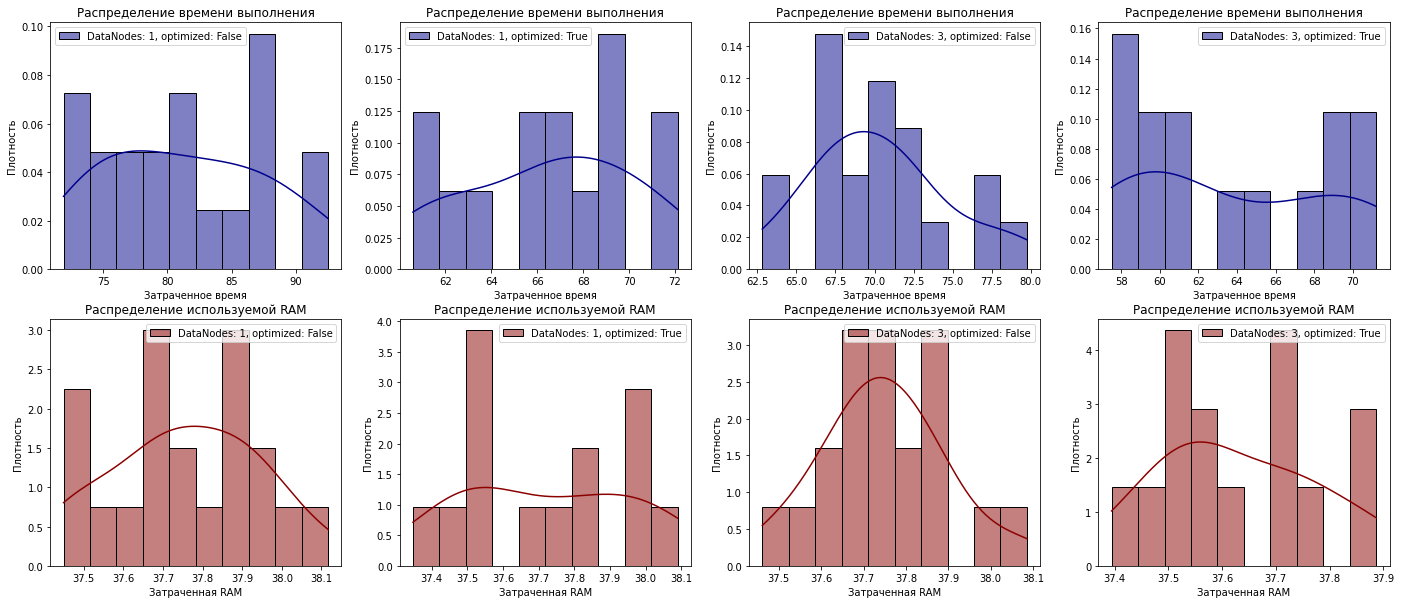

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24,10)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

for i, (datanodes, optimized) in enumerate([(1, "False"), (1, "True"), (3, "False"), (3, "True")]): # идём по числу рассматриваемых DataNode и типу оптимизации
    sns.histplot(res[datanodes][optimized]["Time"], kde=True, stat="density", bins=10, color='darkblue', label=f"DataNodes: {datanodes}, optimized: {optimized}", ax=axes[0][i])
    axes[0][i].set_title("Распределение времени выполнения") # название фигуры
    axes[0][i].set_xlabel("Затраченное время") # подпись по оси OX
    axes[0][i].set_ylabel("Плотность") # подпись по оси OY
    axes[0][i].legend() # отображение подписей графиков

    sns.histplot(res[datanodes][optimized]["RAM"], kde=True, stat="density", bins=10, color='darkred', label=f"DataNodes: {datanodes}, optimized: {optimized}", ax=axes[1][i])
    axes[1][i].set_title("Распределение используемой RAM") # название фигуры
    axes[1][i].set_xlabel("Затраченная RAM") # подпись по оси OX
    axes[1][i].set_ylabel("Плотность") # подпись по оси OY
    axes[1][i].legend() # отображение подписей графиков

plt.show() # показ фигуры

***Выводы:***
* Использование оптимизаций, таких как ```.cache()``` или ```.repartition()``` ускорило работу Spark скрипта на 5-20 секунд.
* Использование большего числа DataNodes ускорило работу Spark скрипта на 1-10 секунд.
* Самым быстрым вариантом оказалось использование 3-х DataNode с оптимизацией, чуть хуже — 1 DataNode с оптимизацией и 3 DataNode без оптимизации, худший вариант — 1 DataNode без оптимизации. 
* Значения используемой RAM у всех вариантов оказались практически одинаковыми.